In [1]:
%load_ext autoreload
%autoreload 2


In [7]:
from datasets import load_dataset
nyuv2_dataset = load_dataset("sayakpaul/nyu_depth_v2", streaming=True)
sample_subset = nyuv2_dataset["train"].shuffle(seed=42).select(range(1000))

AttributeError: 'IterableDataset' object has no attribute 'select'

/Users/vivian/miniforge3/envs/cv/lib/python3.9/site-packages/datasets/features/image.py:338: UserWarning: Downcasting array dtype int64 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


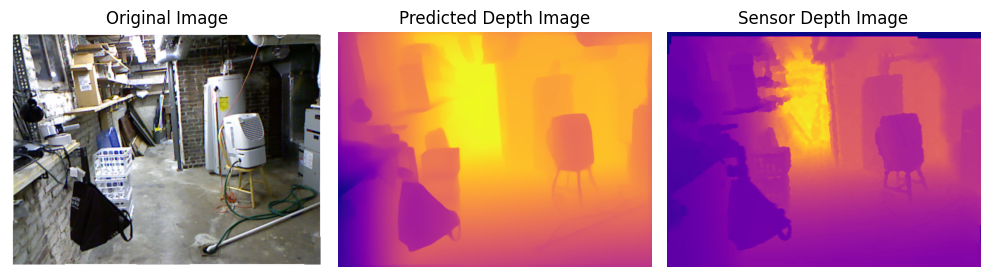

In [ ]:
from transformers import pipeline
from PIL import Image
import cv2
import numpy as np
from io import BytesIO
import requests
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
import torch
import matplotlib.pyplot as plt


# Load Depth Anything model
image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-base-hf")
model = AutoModelForDepthEstimation.from_pretrained(
    "LiheYoung/depth-anything-base-hf", 
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
)

# Load RGB image
next_image = sample_subset[:1]
rgb_image = next_image["image"]
sensor_depth_image = next_image["depth_map"]

# Process image
inputs = image_processor(images=rgb_image, return_tensors="pt")

# Get depth prediction
with torch.no_grad():
    outputs = model(**inputs)

# Post-process the model output to get the final depth map
post_processed_output = image_processor.post_process_depth_estimation(
    outputs,
    target_sizes=[(rgb_image.height, rgb_image.width)],
)
predicted_depth = post_processed_output[0]["predicted_depth"]

#normalize depth sensor image between [0, 1] for visualizing 
sensor_depth_array = np.array(sensor_depth_image)
normalized_sensor_depth_array = (sensor_depth_array - sensor_depth_array.min()) / (sensor_depth_array.max() - sensor_depth_array.min())

#normalize and invert predicted depth image between [0, 1] for visualizing 
predicted_depth_array = np.array(predicted_depth)
predicted_depth_array = (predicted_depth_array - predicted_depth_array.min()) / (predicted_depth_array.max() - predicted_depth_array.min())
predicted_depth_array = 1 - predicted_depth_array  # Invert for visualization

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(rgb_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(predicted_depth_array, cmap="plasma")
plt.title("Predicted Depth Image")
plt.axis("off")
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.imshow(normalized_sensor_depth_array, cmap="plasma")
plt.title("Sensor Depth Image")
plt.axis("off")
plt.tight_layout()
plt.show()

plt.show()



In [ ]:
# call error map on difference between predicted and sensor depth
from error_map import error_map_from_arrays

percent_error = error_map_from_arrays(normalized_sensor_depth_array, predicted_depth_array)

#create the plot
plt.figure(figsize=(10, 8))
im = plt.imshow(percent_error, cmap='RdYlGn_r')
plt.clim(0, 150)
plt.colorbar(im, label='Percent Error (%)')

plt.title('Percent Error Map')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')



In [ ]:
# get plot of sensor depth value vs avg predicted error

plt.figure(figsize=(10, 5))
plt.title('Sensor Depth vs Predicted Error')
plt.xlabel('Value of sensor depth (m)')         
plt.ylabel('Predicted Error (%)')

xy_values = [(sensor_depth_array.flatten()[i], percent_error.flatten()[i]) for i in range(sensor_depth_array.size)]
x_values, y_values = zip(*xy_values)
filtered_xy_values = [(x, y) for x, y in xy_values if y <= 300]
filtered_x_values, filtered_y_values = zip(*filtered_xy_values)
plt.scatter(filtered_x_values, filtered_y_values, alpha=0.5, s=1)
plt.legend()
plt.show()

In [ ]:
# From filtered x and filtered y values, create bins for x values and calculate the mean of y values in each bin
import numpy as np
x_bins = np.linspace(0, np.max(filtered_x_values), 40)  # Create 40 bins 
y_binned_means = []
for i in range(len(x_bins) - 1):
    bin_mask = (filtered_x_values >= x_bins[i]) & (filtered_x_values < x_bins[i + 1])
    if np.any(bin_mask):
        y_binned_means.append(np.mean(np.array(filtered_y_values)[bin_mask]))
    else:
        y_binned_means.append(0)
plt.figure(figsize=(10, 5))
plt.title('Sensor Depth vs Predicted Error (Binned)')
plt.xlabel('Value of sensor depth (m)')
plt.ylabel('Mean Predicted Error (%)')
plt.bar(x_bins[:-1], y_binned_means, width=np.diff(x_bins), alpha=0.5, align='edge', edgecolor='black')
plt.show()


In [ ]:
# run encoder decoder to get refined sensor depth image from predicted depth image
import EncoderDecoder
